In [1]:
config='TROPICO12'
case='TRPC12N00'
year='2013'
plots_surf=True
plot_eke=False
plot_rms=False
plot_psi=False
plots_100m=False
plots_1000m=False

In [2]:
# General and file management
import numpy as np
import numpy.ma as ma
import xarray as xr
from netCDF4 import Dataset
import dask.array as da

#For the plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.ticker as mticker

import cartopy
cartopy.config['pre_existing_data_dir'] = '/scratch/cnt0024/hmg2840/albert7a/DEV/git/cartopy_data'
import cartopy.crs as ccrs
import cmocean

import warnings
warnings.filterwarnings('ignore')

#Jupyter magics
%matplotlib inline

In [3]:
#Parameters for 1 node HSW24
ask_workers=28
memory='120GB'

In [4]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='pangeo',walltime='00:30:00',
                       job_extra=['--constraint=HSW24','--exclusive',
                                  '--nodes=1'],memory=memory,
                       interface='ib0') 
cluster.scale(ask_workers)
c= Client(cluster)
c

#check if the job is running by typing squeue -u yourlogin (or qm if you have the alias)

Client Scheduler: tcp://172.30.100.1:46224 Dashboard: http://172.30.100.1:33187/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [8]:
#Check the ressources
from dask.utils import ensure_dict, format_bytes
    
wk = c.scheduler_info()["workers"]

text="Workers= " + str(len(wk))
memory = [w["memory_limit"] for w in wk.values()]
cores = sum(w["nthreads"] for w in wk.values())
text += ", Cores=" + str(cores)
if all(memory):
    text += ", Memory=" + format_bytes(sum(memory))
print(text)


Workers= 14, Cores=56, Memory=239.96 GB


In [9]:
# Open grid and mask
if config == 'CALEDO60':
    dscoord=xr.open_dataset('/store/brodeau/TROPICO12/TROPICO12.L125-I/NST/1_coordinates_TROPICO12.nc')
    dsmask=xr.open_dataset('/store/brodeau/TROPICO12/TROPICO12.L125-I/NST/1_mesh_mask_TROPICO12_L125_tr21.nc',drop_variables={'x','y'})
if config == 'TROPICO12':
    dscoord=xr.open_dataset('/store/brodeau/TROPICO12/TROPICO12.L125-I/coordinates_TROPICO12.nc')
    dsmask=xr.open_dataset('/store/brodeau/TROPICO12/TROPICO12.L125-I/mesh_mask_TROPICO12_L125_tr21_UPDATED.nc',drop_variables={'x','y'})


In [10]:
# Generic plot 
def plot_surf(ax, proj, var, cmap,vmin,vmax,label,title,month):
    ax.coastlines()
    if config == 'CALEDO60':
        gl=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), xlocs=[158,160,162,164,166,168,170,172])
    if config == 'TROPICO12':
        ax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), xlocs=[120,140,160,180,200,220,240,260,280])
        gl=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), xlocs=[120,140,160,180,-160,-140,-120,-100,-80])
    gl.ylabels_right = False
    cs = plt.pcolormesh(dscoord.nav_lon-cm, dscoord.nav_lat, var,transform=proj,cmap=cmap,
                    vmin=vmin,vmax=vmax)
    cbar = plt.colorbar(cs,orientation='vertical',shrink=0.5,label='deg C')
    ax.set_title(title)


In [11]:
# Make plots of every surface mean fields
cm = 180
proj = ccrs.PlateCarree(central_longitude=cm)
month_name={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',
            8:'August',9:'September',10:'October',11:'November',12:'December'}

if config == 'CALEDO60':
    figsize=[24,20]
if config == 'TROPICO12':
    figsize=[30,15]

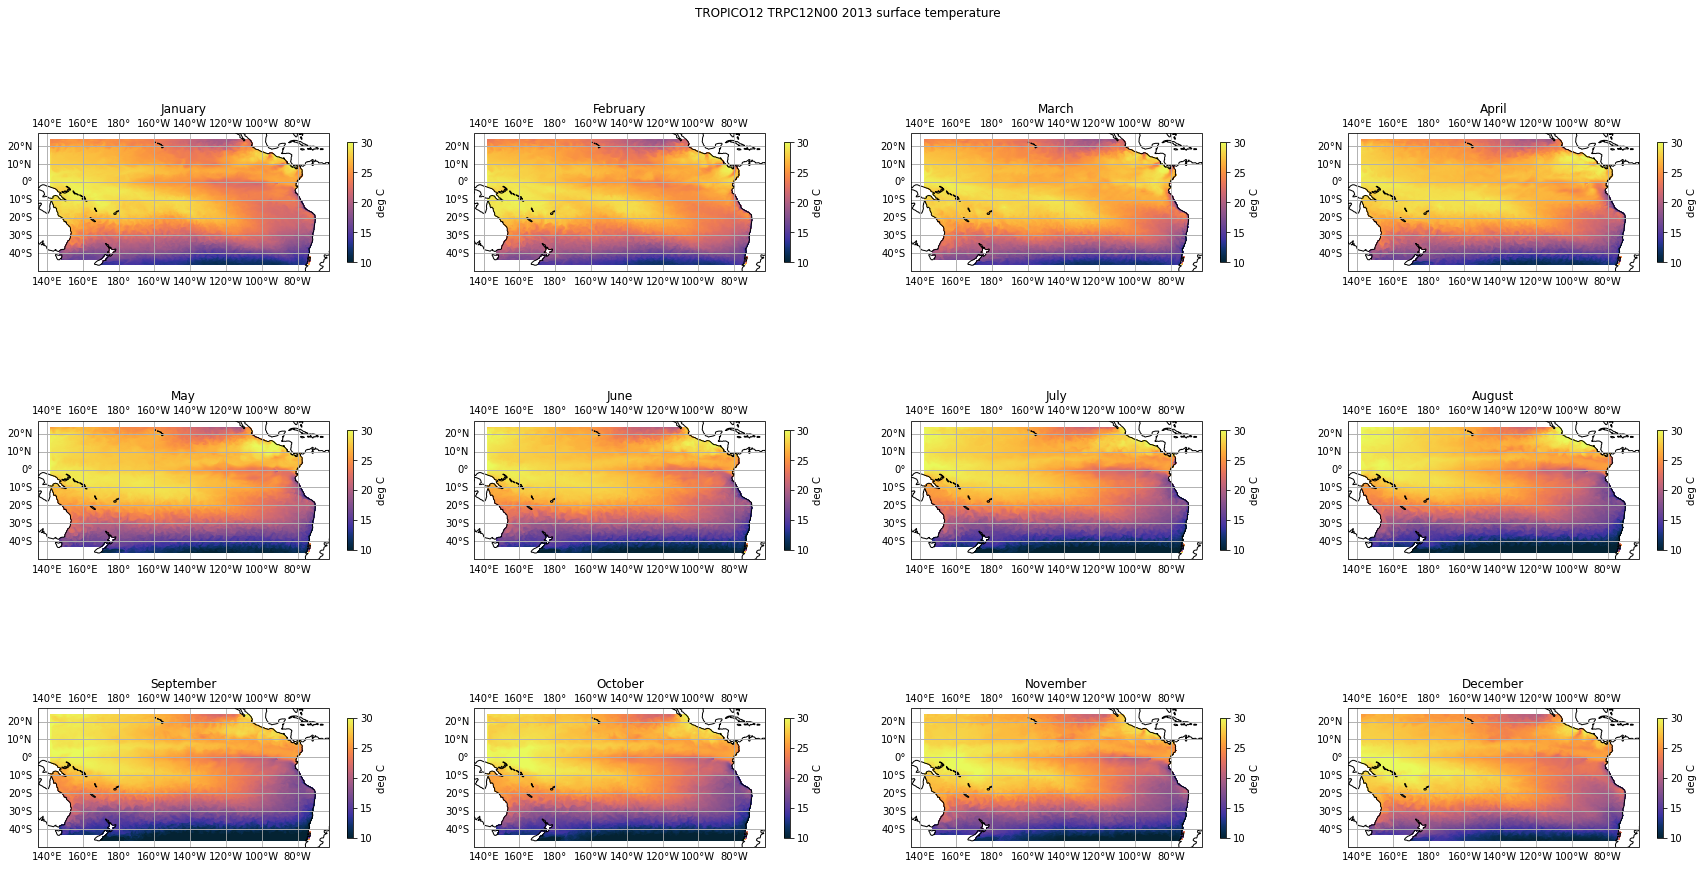

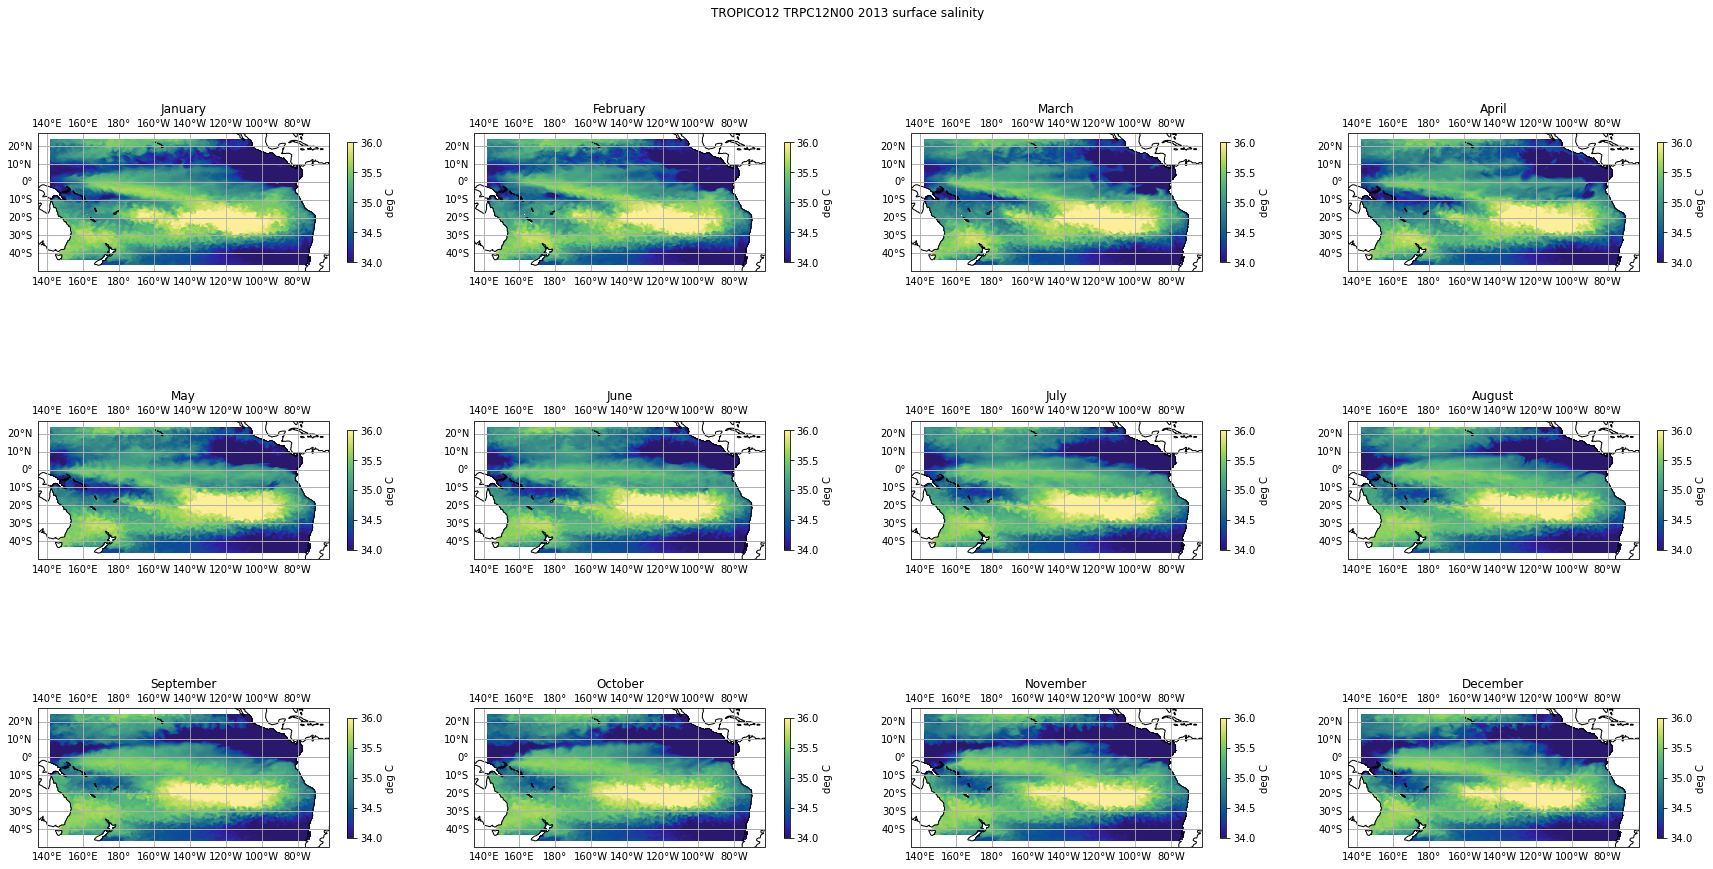

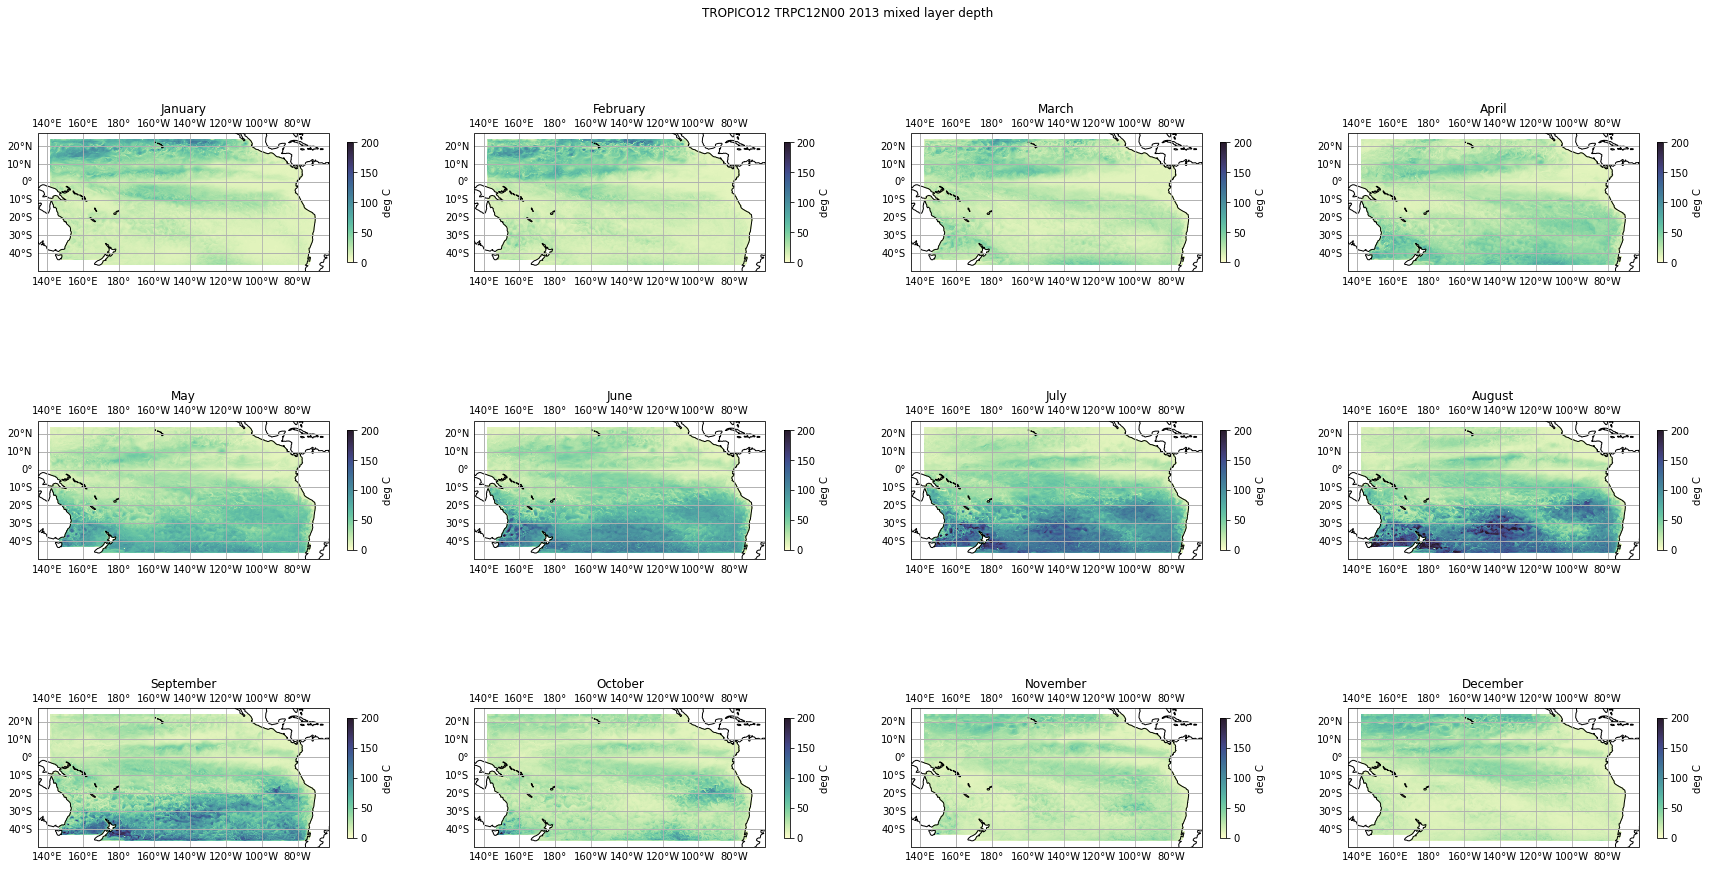

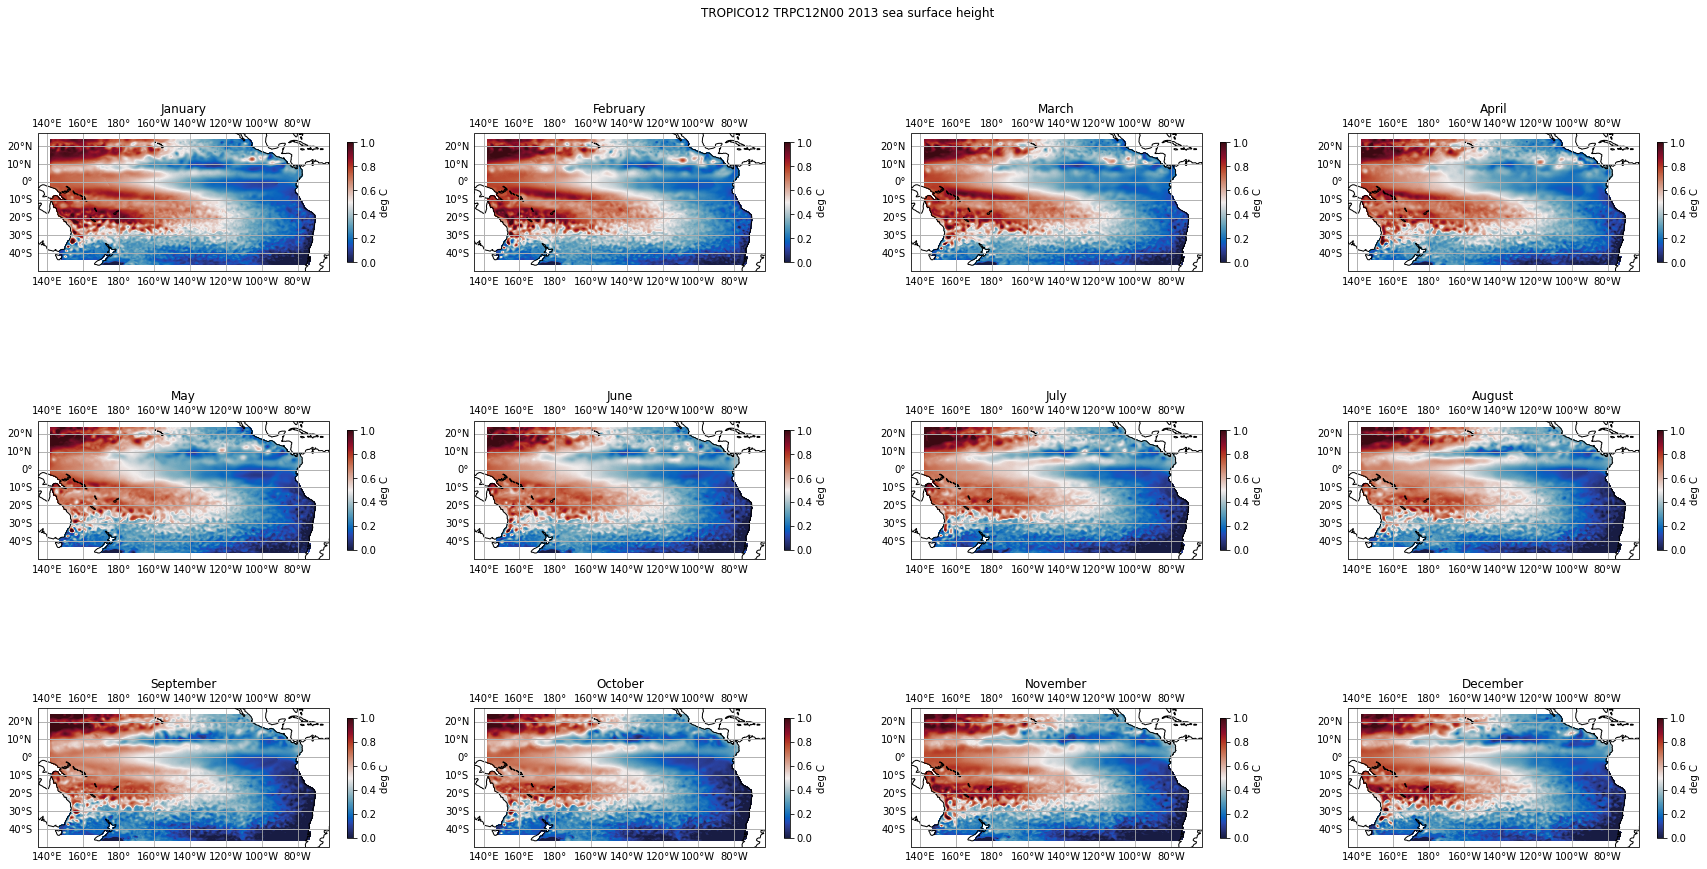

In [12]:
if plots_surf:
    fig = plt.figure(figsize=figsize)
    plt.suptitle(config+' '+case+' '+year+' surface temperature', y=0.95)
    for month in np.arange(1,13):
        mm = "{:02d}".format(month)
        ds=xr.open_dataset('/scratch/cnt0024/ige2071/aalbert/'+config+'/'+config+'-'+case+'-MEAN/1m/'+year+'/'+config+'-'+case+'_1m_'+year+mm+'_gridT-2D.nc',chunks={'x':1000,'y':500})

        ax = fig.add_subplot(3, 4, month, projection=proj)
        tmean_surf=ds.tos[0]
        tmask_surf=dsmask.tmask[0,0]
        tmeansurf_mask=ma.masked_where(tmask_surf==0.,tmean_surf)
        plot_surf(ax, proj, tmeansurf_mask, cmocean.cm.thermal,10,30,'deg C',
                          month_name[month],month)
    plt.tight_layout()
    plt.savefig('plots/'+config+'-'+case+'_monthly_surface_temperature_'+year+'.png', bbox_inches='tight')

    fig = plt.figure(figsize=figsize)
    plt.suptitle(config+' '+case+' '+year+' surface salinity', y=0.95)
    for month in np.arange(1,13):
        mm = "{:02d}".format(month)
        ds=xr.open_dataset('/scratch/cnt0024/ige2071/aalbert/'+config+'/'+config+'-'+case+'-MEAN/1m/'+year+'/'+config+'-'+case+'_1m_'+year+mm+'_gridT-2D.nc',chunks={'x':1000,'y':500})

        ax = fig.add_subplot(3, 4, month, projection=proj)
        smean_surf=ds.sos[0]
        smeansurf_mask=ma.masked_where(tmask_surf==0.,smean_surf)
        plot_surf(ax, proj, smeansurf_mask, cmocean.cm.haline,34,36,'PSU',month_name[month],month)
    plt.tight_layout()
    plt.savefig('plots/'+config+'-'+case+'_monthly_mean_surface_salinity_'+year+'.png', bbox_inches='tight')

    fig = plt.figure(figsize=figsize)
    plt.suptitle(config+' '+case+' '+year+' mixed layer depth', y=0.95)
    for month in np.arange(1,13):
        mm = "{:02d}".format(month)
        ds=xr.open_dataset('/scratch/cnt0024/ige2071/aalbert/'+config+'/'+config+'-'+case+'-MEAN/1m/'+year+'/'+config+'-'+case+'_1m_'+year+mm+'_gridT-2D.nc',chunks={'x':1000,'y':500})

        ax = fig.add_subplot(3, 4, month, projection=proj)
        mldmean=ds.mldr10_1[0]
        mldmean_mask=ma.masked_where(tmask_surf==0.,mldmean)
        plot_surf(ax, proj, mldmean_mask, cmocean.cm.deep,0,200,'m',month_name[month],month)
    plt.tight_layout()
    plt.savefig('plots/'+config+'-'+case+'_monthly_mean_mld_'+year+'.png', bbox_inches='tight')

    fig = plt.figure(figsize=figsize)
    plt.suptitle(config+' '+case+' '+year+' sea surface height', y=0.95)
    for month in np.arange(1,13):
        mm = "{:02d}".format(month)
        ds=xr.open_dataset('/scratch/cnt0024/ige2071/aalbert/'+config+'/'+config+'-'+case+'-MEAN/1m/'+year+'/'+config+'-'+case+'_1m_'+year+mm+'_gridT-2D.nc',chunks={'x':1000,'y':500})
        ax = fig.add_subplot(3, 4, month, projection=proj)
        sshmean=ds.zos[0]
        sshmean_mask=ma.masked_where(tmask_surf==0.,sshmean)
        plot_surf(ax, proj, sshmean_mask, cmocean.cm.balance,0,1,'m',
                      month_name[month],month)
    plt.tight_layout()
    plt.savefig('plots/'+config+'-'+case+'_monthly_mean_ssh_'+year+'.png', bbox_inches='tight')




In [13]:
if plot_eke:
    fig = plt.figure(figsize=figsize)
    plt.suptitle(config+' '+case+' '+year+' surface eke', y=0.95)
    for month in np.arange(1,13):
        mm = "{:02d}".format(month)
        ds=xr.open_dataset('/scratch/cnt0024/ige2071/aalbert/'+config+'/'+config+'-'+case+'-MEAN/1m/'+year+'/'+config+'-'+case+'_1m_'+year+mm+'_EKE.nc',chunks={'x':1000,'y':500})

        ax = fig.add_subplot(3, 4, month, projection=proj)
        ekemean_surf=ds.voeke[0,0]
        tmask_surf=dsmask.tmask[0,0]
        ekemeansurf_mask=ma.masked_where(tmask_surf==0.,ekemean_surf)
        plot_surf(ax, proj, 10000*ekemeansurf_mask, cmocean.cm.amp,0,2500,'1e4m2s',month_name[month],month)
    plt.tight_layout()
    plt.savefig('plots/'+config+'-'+case+'_monthly_mean_surf_eke_'+year+'.png', bbox_inches='tight')

In [14]:
# Make plots of every surface mean fields
if plot_rms:
    fig = plt.figure(figsize=figsize)
    plt.suptitle(config+' '+case+' '+year+' surface std of ssh', y=0.95)
    for month in np.arange(1,13):
        mm = "{:02d}".format(month)
        ds=xr.open_dataset('/scratch/cnt0024/ige2071/aalbert/'+config+'/'+config+'-'+case+'-MEAN/1m/'+year+'/'+config+'-'+case+'_1m_'+year+mm+'_RMSSSH.nc',chunks={'x':1000,'y':500})

        ax = fig.add_subplot(3, 4, month, projection=proj)
        ekemean_surf=ds.zos_rms[0]
        tmask_surf=dsmask.tmask[0,0]
        ekemeansurf_mask=ma.masked_where(tmask_surf==0.,ekemean_surf)
        plot_surf(ax, proj, ekemeansurf_mask, cmocean.cm.amp,0,0.2,'m',month_name[month],month)
    plt.tight_layout()
    plt.savefig('plots/'+config+'-'+case+'_monthly_mean_rmsssh_'+year+'.png', bbox_inches='tight') 

In [15]:
# Make plots of every surface mean fields
if plot_psi:
    fig = plt.figure(figsize=figsize)
    plt.suptitle(config+' '+case+' '+year+' surface streamfunction', y=0.95)
    for month in np.arange(1,13):
        mm = "{:02d}".format(month)
        ds=xr.open_dataset('/scratch/cnt0024/ige2071/aalbert/'+config+'/'+config+'-'+case+'-MEAN/1m/'+year+'/'+config+'-'+case+'_1m_'+year+mm+'_PSI.nc',chunks={'x':1000,'y':500})
        ax = fig.add_subplot(3, 4, month, projection=proj)
        ekemean_surf=ds.sobarstf[0]
        tmask_surf=dsmask.tmask[0,0]
        ekemeansurf_mask=ma.masked_where(tmask_surf==0.,ekemean_surf)
        plot_surf(ax, proj, 1e-7*ekemeansurf_mask, 'Blues',-4,4,'',month_name[month],month)
    plt.tight_layout()
    plt.savefig('plots/'+config+'-'+case+'_monthly_mean_surf_psi_'+year+'.png', bbox_inches='tight')    


In [16]:
if plots_100m:
    fig = plt.figure(figsize=figsize)
    plt.suptitle(config+' '+case+' '+year+' 100m temperature', y=0.95)
    for month in np.arange(1,13):
        mm = "{:02d}".format(month)
        ds=xr.open_dataset('/scratch/cnt0024/ige2071/aalbert/'+config+'/'+config+'-'+case+'-MEAN/1m/'+year+'/'+config+'-'+case+'_1m_'+year+mm+'_gridT.nc',chunks={'x':1000,'y':500})

        ax = fig.add_subplot(3, 4, month, projection=proj)
        tmean_surf=ds.thetao[0,42]
        tmask_surf=dsmask.tmask[0,42]
        tmeansurf_mask=ma.masked_where(tmask_surf==0.,tmean_surf)
        plot_surf(ax, proj, tmeansurf_mask, cmocean.cm.thermal,10,30,'deg C',
                          month_name[month],month)
    plt.tight_layout()
    plt.savefig('plots/'+config+'-'+case+'_monthly_100m_temperature_'+year+'.png', bbox_inches='tight')

    fig = plt.figure(figsize=figsize)
    plt.suptitle(config+' '+case+' '+year+' 100m salinity', y=0.95)
    for month in np.arange(1,13):
        mm = "{:02d}".format(month)
        ds=xr.open_dataset('/scratch/cnt0024/ige2071/aalbert/'+config+'/'+config+'-'+case+'-MEAN/1m/'+year+'/'+config+'-'+case+'_1m_'+year+mm+'_gridS.nc',chunks={'x':1000,'y':500})

        ax = fig.add_subplot(3, 4, month, projection=proj)
        smean_surf=ds.so[0,42]
        smeansurf_mask=ma.masked_where(tmask_surf==0.,smean_surf)
        plot_surf(ax, proj, smeansurf_mask, cmocean.cm.haline,34,36,'PSU',month_name[month],month)
    plt.tight_layout()
    plt.savefig('plots/'+config+'-'+case+'_monthly_mean_100m_salinity_'+year+'.png', bbox_inches='tight')

    fig = plt.figure(figsize=figsize)
    plt.suptitle(config+' '+case+' '+year+' 100m eke', y=0.95)
    for month in np.arange(1,13):
        mm = "{:02d}".format(month)
        ds=xr.open_dataset('/scratch/cnt0024/ige2071/aalbert/'+config+'/'+config+'-'+case+'-MEAN/1m/'+year+'/'+config+'-'+case+'_1m_'+year+mm+'_EKE.nc',chunks={'x':1000,'y':500})

        ax = fig.add_subplot(3, 4, month, projection=proj)
        ekemean_surf=ds.voeke[0,42]
        ekemeansurf_mask=ma.masked_where(tmask_surf==0.,ekemean_surf)
        plot_surf(ax, proj, 10000*ekemeansurf_mask, cmocean.cm.amp,0,2500,'1e4m2s',month_name[month],month)
    plt.tight_layout()
    plt.savefig('plots/'+config+'-'+case+'_monthly_mean_100m_eke_'+year+'.png', bbox_inches='tight')

In [17]:
if plots_1000m:
    fig = plt.figure(figsize=figsize)
    plt.suptitle(config+' '+case+' '+year+' 1000m temperature', y=0.95)
    for month in np.arange(1,13):
        mm = "{:02d}".format(month)
        ds=xr.open_dataset('/scratch/cnt0024/ige2071/aalbert/'+config+'/'+config+'-'+case+'-MEAN/1m/'+year+'/'+config+'-'+case+'_1m_'+year+mm+'_gridT.nc',chunks={'x':1000,'y':500})

        ax = fig.add_subplot(3, 4, month, projection=proj)
        tmean_surf=ds.thetao[0,75]
        tmask_surf=dsmask.tmask[0,75]
        tmeansurf_mask=ma.masked_where(tmask_surf==0.,tmean_surf)
        plot_surf(ax, proj, tmeansurf_mask, cmocean.cm.thermal,2,6,'deg C',
                          month_name[month],month)
    plt.tight_layout()
    plt.savefig('plots/'+config+'-'+case+'_monthly_1000m_temperature_'+year+'.png', bbox_inches='tight')

    fig = plt.figure(figsize=figsize)
    plt.suptitle(config+' '+case+' '+year+' 1000m salinity', y=0.95)
    for month in np.arange(1,13):
        mm = "{:02d}".format(month)
        ds=xr.open_dataset('/scratch/cnt0024/ige2071/aalbert/'+config+'/'+config+'-'+case+'-MEAN/1m/'+year+'/'+config+'-'+case+'_1m_'+year+mm+'_gridS.nc',chunks={'x':1000,'y':500})

        ax = fig.add_subplot(3, 4, month, projection=proj)
        smean_surf=ds.so[0,75]
        smeansurf_mask=ma.masked_where(tmask_surf==0.,smean_surf)
        plot_surf(ax, proj, smeansurf_mask, cmocean.cm.haline,34.2,34.8,'PSU',month_name[month],month)
    plt.tight_layout()
    plt.savefig('plots/'+config+'-'+case+'_monthly_mean_1000m_salinity_'+year+'.png', bbox_inches='tight')

    fig = plt.figure(figsize=figsize)
    plt.suptitle(config+' '+case+' '+year+' 1000m eke', y=0.95)
    for month in np.arange(1,13):
        mm = "{:02d}".format(month)
        ds=xr.open_dataset('/scratch/cnt0024/ige2071/aalbert/'+config+'/'+config+'-'+case+'-MEAN/1m/'+year+'/'+config+'-'+case+'_1m_'+year+mm+'_EKE.nc',chunks={'x':1000,'y':500})

        ax = fig.add_subplot(3, 4, month, projection=proj)
        ekemean_surf=ds.voeke[0,75]
        ekemeansurf_mask=ma.masked_where(tmask_surf==0.,ekemean_surf)
        plot_surf(ax, proj, 10000*ekemeansurf_mask, cmocean.cm.amp,0,200,'1e4m2s',month_name[month],month)
    plt.tight_layout()
    plt.savefig('plots/'+config+'-'+case+'_monthly_mean_1000m_eke_'+year+'.png', bbox_inches='tight')

In [ ]:
c.close()